# labeling MNIST data with a convolutional neural network



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

c:\Users\Alessandro\anaconda3\envs\tfgpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print('TensorFlow version:',tf.__version__)
print('Keras version:',tf.keras.__version__)

TensorFlow version: 2.10.0
Keras version: 2.10.0


In [3]:
print(tf.__file__)
print(tf.keras.__file__)

c:\Users\Alessandro\anaconda3\envs\tfgpu\lib\site-packages\tensorflow\__init__.py
c:\Users\Alessandro\anaconda3\envs\tfgpu\lib\site-packages\keras\api\_v2\keras\__init__.py


In [4]:
# first, we load the data:

data = pd.read_csv('digit-recognizer/train.csv')
data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Data preparation:

Now, the first column are the labels, the remaining 784 columns are the pixel values. I have to:

1) split the data in train and validation sets

2) split validation sets into features and labels

3) correctly format features intoa a 28x28 grid

In [5]:
def data_prep(input_df,verbose=False):
    rng = np.random.default_rng(seed=123)
    data=np.array(input_df)
    m,n=data.shape
    rng.shuffle(data)
    #train_size=int(m*split)
    #x_val=data[:train_size,1:]#the last 784 columns of the first train_size rows are the training features
    #y_val=data[:train_size,0]
    x_train=data[:,1:]
    y_train=data[:,0]
    x_train=(x_train.reshape(-1,28,28)/255.).astype('float32')
    #x_val=(x_val.reshape(-1,28,28)/255.).astype('float32')
    if verbose:
        print(x_train.shape)
    y_train = tf.keras.utils.to_categorical(y_train)
    #y_val = tf.keras.utils.to_categorical(y_val)
    return x_train,y_train

In [6]:
x_train, y_train= data_prep(data, verbose=True)

(42000, 28, 28)


In [7]:
#x_train = tf.expand_dims(x_train, axis=-1)
#x_val = tf.expand_dims(x_val, axis=-1)
x_train = x_train.reshape(-1, 28, 28, 1)
#x_val = x_val.reshape(-1, 28, 28, 1)

In [9]:
x_train=tf.convert_to_tensor(x_train)
y_train=tf.convert_to_tensor(y_train)

#### Now I have the data prepared, I can construct a CNN and feed data to it:

In [10]:
def create_model():
    '''simple convolutional neural network'''
    model=tf.keras.models.Sequential(name='CNN_MNIST')
    model.add(tf.keras.layers.Conv2D(10,4,strides=(1,1), activation='relu',input_shape=(28,28,1,),name='Conv1'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Conv2D(10,2,activation='relu',))
    print(model.output_shape)
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=100,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=100,activation='relu'))
    model.add(tf.keras.layers.Dense(units=10,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    print(model.output_shape)
    return model

In [12]:
def visualize_example(x,y,index):
    #img=np.reshape(x[index],(28,28))
    img=x[index]*255.
    label=np.argmax(y[index])
    print('Example number: ', index, '\nLabel: ' , label)
    plt.gray()
    plt.imshow(img, interpolation='nearest')
    plt.show()


In [13]:
def test_model(model,x,y,ind,show_probability=False):
    example=x[None,ind]
    if show_probability:
        print(model(example))
    prediction=np.argmax(model.predict(example))
    print('Prediction: ', prediction)
    visualize_example(x,y,ind)


In [14]:
model=create_model()
print(model.summary())

(None, 11, 11, 10)
(None, 10)
Model: "CNN_MNIST"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 25, 25, 10)        170       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 10)       0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 11, 11, 10)        410       
                                                                 
 dropout (Dropout)           (None, 11, 11, 10)        0         
                                                                 
 flatten (Flatten)           (None, 1210)              0         
                                                                 
 dense (Dense)               (None, 100)               121100    
                           

In [15]:
x_train.shape#(42000, 28, 28,1)

TensorShape([42000, 28, 28, 1])

In [16]:
history = model.fit(x_train, y_train,batch_size=30, epochs=50, validation_split=0.3)

Epoch 1/50
980/980 [==============================] - 12s 10ms/step - loss: 0.3154 - accuracy: 0.9034 - val_loss: 0.1150 - val_accuracy: 0.9660
Epoch 2/50
980/980 [==============================] - 8s 8ms/step - loss: 0.1109 - accuracy: 0.9656 - val_loss: 0.0699 - val_accuracy: 0.9775
Epoch 3/50
980/980 [==============================] - 8s 8ms/step - loss: 0.0808 - accuracy: 0.9750 - val_loss: 0.0602 - val_accuracy: 0.9817
Epoch 4/50
980/980 [==============================] - 8s 9ms/step - loss: 0.0664 - accuracy: 0.9778 - val_loss: 0.0582 - val_accuracy: 0.9821
Epoch 5/50
980/980 [==============================] - 8s 8ms/step - loss: 0.0571 - accuracy: 0.9814 - val_loss: 0.0490 - val_accuracy: 0.9859
Epoch 6/50
980/980 [==============================] - 8s 8ms/step - loss: 0.0464 - accuracy: 0.9846 - val_loss: 0.0499 - val_accuracy: 0.9855
Epoch 7/50
980/980 [==============================] - 8s 9ms/step - loss: 0.0435 - accuracy: 0.9863 - val_loss: 0.0492 - val_accuracy: 0.9860
Epoc

In [17]:
model.predict(x_train[None,np.random.randint(0,4000)])

1/1 [==============================] - 0s 119ms/step


array([[5.4934544e-20, 2.1026333e-23, 2.5856676e-26, 2.3046348e-16,
        2.6577396e-19, 1.0000000e+00, 2.1890700e-17, 2.9054065e-24,
        2.1903814e-17, 7.3035258e-12]], dtype=float32)

tf.Tensor(
[[9.9562374e-14 2.2596724e-15 1.0683149e-14 3.2455749e-10 2.6373267e-13
  1.8796948e-11 1.4430349e-12 1.3614216e-14 1.0000000e+00 1.4003024e-09]], shape=(1, 10), dtype=float32)
1/1 [==============================] - 0s 26ms/step
Prediction:  8
Example number:  26353 
Label:  8


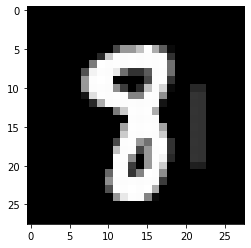

In [18]:
test_model(model,x_train,y_train,np.random.randint(0,x_train.shape[0]),show_probability=True)

In [43]:
from datetime import datetime

In [44]:
timestamp=datetime.today().strftime('%Y%m%d%H%M%S')

In [45]:
# Save the trained model
savemodel=True
modelFileName = 'models/mnist_CNNv1_'+timestamp+'.h5'
if savemodel:
    model.save(modelFileName)
    #del model  # deletes the existing model variable
    print('model saved as', modelFileName)

model saved as models/mnist_CNNv120221110131514.h5


Next: obtain confusion matrix

In [20]:
model = tf.keras.models.load_model(modelFileName)


1313/1313 [==============================] - 5s 3ms/step


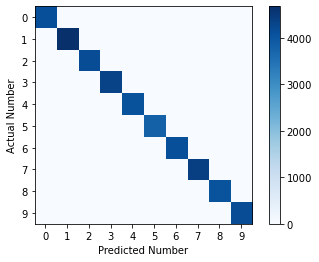

              precision    recall  f1-score   support

           0      0.997     0.998     0.998      4132
           1      0.997     0.999     0.998      4684
           2      0.997     0.995     0.996      4177
           3      1.000     0.992     0.996      4351
           4      0.996     0.997     0.996      4072
           5      0.993     0.999     0.996      3795
           6      0.997     0.998     0.998      4137
           7      0.995     0.997     0.996      4401
           8      0.996     0.996     0.996      4063
           9      0.995     0.994     0.995      4188

    accuracy                          0.996     42000
   macro avg      0.996     0.996     0.996     42000
weighted avg      0.996     0.996     0.996     42000



In [22]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
#import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#import matplotlib.pyplot as plt
%matplotlib inline


class_probabilities = model.predict(x_train)
predictions = np.argmax(class_probabilities, axis=1)
true_labels = np.argmax(y_train,axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks, rotation=0)
plt.yticks(tick_marks, tick_marks)
plt.xlabel("Predicted Number")
plt.ylabel("Actual Number")
plt.show()
#print(cm)
print(classification_report(true_labels,predictions,digits=3))

In [23]:
kaggle_test=pd.read_csv('digit-recognizer/test.csv')
kaggle_test.shape
kaggle_test = np.array(kaggle_test).reshape(-1, 28, 28, 1)


In [24]:
kaggle_predictions=model.predict(kaggle_test)

875/875 [==============================] - 2s 2ms/step


In [25]:
print(np.argmax(kaggle_predictions,axis=1).shape)

(28000,)


tf.Tensor([[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)
1/1 [==============================] - 0s 86ms/step
Prediction:  5
Example number:  22657 
Label:  5


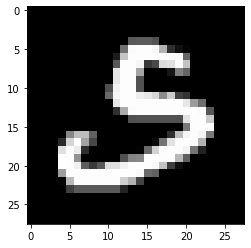

In [26]:
test_model(model,kaggle_test,kaggle_predictions,np.random.randint(0,28000),show_probability=True)

In [27]:
sample=pd.read_csv('digit-recognizer/sample_submission.csv')
sample['Label']=np.argmax(kaggle_predictions,axis=1)
sample

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [28]:
sample.to_csv('kaggle_predictions_CNN.csv',index=None)